# Final Project on Supervised Learning

### Group Members: Eric Topmiller, Viphu Nguyen, David Gigremosa, Paul Rozario
### INST414

### LAN and WAN Response Analysis 
- Description: The source of our data comes from the variablity of a LAN network when it is connecting to the Internet. The data is collected by the ping response time from the devices of the local internet router and to the first-hop server on the internet.


Question to Answer: What is the worst time of day for ping response with ethernet and wireless for both LAN and WAN?

Import libraries

In [1]:


import sys
# sys.path.append('C:\\Users\\mgwyn_dgsghje\\AppData\\Roaming\\Python\\Python38\\Scripts')
# !pip install numpy --user --upgrade --ignore-installed
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn import preprocessing
import matplotlib.pyplot as plt
from matplotlib import style

Set the dataset from the network csv

In [2]:

df = pd.read_csv('ping_data_rp829c7e0e_eth.csv')
df.head()
df.sort_values('timestamp', inplace=True)

### Data Wrangling and Filtering the Data
- Done by Viphu Nguyen and Eric Topmiller

Finding the missing values from the ping dataset


In [3]:
df.isna().sum()

timestamp      0
location       0
source         0
local_dest     0
local_avg      0
remote_dest    0
remote_avg     0
dtype: int64

Duplicate the dataframe in case of crashes


In [4]:
df1 = df.copy()

Removing unncessary columns from the ping dataset


In [5]:
df1 = df1.drop(['location', 'local_dest', 'remote_dest'], axis = 1)
df1

,timestamp,source,local_avg,remote_avg
0,1.559041e+09,ethernet,0.19,8.14
1,1.559041e+09,ethernet,0.15,7.75
2,1.559041e+09,ethernet,0.15,8.68
3,1.559041e+09,ethernet,0.15,8.08
4,1.559041e+09,ethernet,0.15,8.20
...,...,...,...,...
69740,1.559691e+09,ethernet,0.15,8.70
69741,1.559691e+09,ethernet,0.15,8.43
69742,1.559691e+09,ethernet,0.15,8.71
69743,1.559691e+09,ethernet,0.15,8.42


#### *Each header definition*
- Timestamp: The current time of an event that is recorded
- Source: Network Source
- Local_avg: Response Time for local network (ms)
- Remote_avg: Response time for remote network (ms)

Create a column that is the start of the range of hours of the day, show the head, show it has all 24 hours of the day


In [6]:
#df1['hour'] = (df['timestamp'].astype(int) % 86400) / 14400
df1['hour'] = (df['timestamp'].astype(int) % 86400) / 28800
df1['hour'] = df1['hour'].astype(int)
print(df1.head())
print(df1['hour'].unique())
print(df1.info())

      timestamp    source  local_avg  remote_avg  hour
0  1.559041e+09  ethernet       0.19        8.14     1
1  1.559041e+09  ethernet       0.15        7.75     1
2  1.559041e+09  ethernet       0.15        8.68     1
3  1.559041e+09  ethernet       0.15        8.08     1
4  1.559041e+09  ethernet       0.15        8.20     1
[1 2 0]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 69745 entries, 0 to 69744
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   timestamp   69745 non-null  float64
 1   source      69745 non-null  object 
 2   local_avg   69745 non-null  float64
 3   remote_avg  69745 non-null  float64
 4   hour        69745 non-null  int32  
dtypes: float64(3), int32(1), object(1)
memory usage: 2.9+ MB
None


Remove the rows with avg of 9999.9999 since they are failures and will skew the data


count    69745.000000
mean       782.506427
std       2685.044084
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       9999.999900
Name: local_avg, dtype: float64
count    69745.000000
mean       793.170246
std       2682.048286
min          4.020000
25%          8.180000
50%          8.620000
75%          9.570000
max       9999.999900
Name: remote_avg, dtype: float64


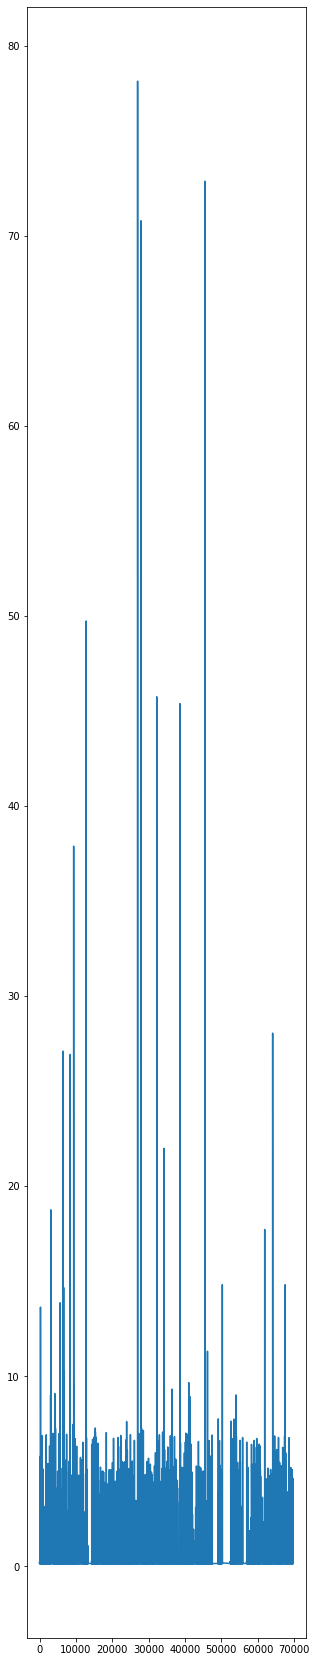

In [7]:
#df1 = df1[(df1['local_avg'] != 9999) & (df1['remote_avg'] < 1000.0)]
df1 = df1.reset_index()
print(df1['local_avg'].describe())
print(df1['remote_avg'].describe())
# for plotting throw out the large values so we can better see the more common local_avg
df_small_local = df1[(df1['local_avg'] < 500)]
df_small_local['local_avg'].plot(figsize=(5,30))
plt.show()

Find the quartiles of the time data so we can create local average categorical variable


In [8]:
print(df1['local_avg'].describe())

count    69745.000000
mean       782.506427
std       2685.044084
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       9999.999900
Name: local_avg, dtype: float64


Create the categorical variable local_delay for the local delay of low, average, high using the quartiles

We will leave in the 9999.9999 since they probably represent failures and should be placed the high



In [9]:
bins = [float('-inf'), 0.149, 0.15, float('inf')]
labels = ['Small', 'Medium', 'Large']
df1['local_delay'] = pd.cut(df1['local_avg'], bins=bins, labels=labels)
df1.head()
print(df1['local_delay'].unique())


['Large', 'Medium', 'Small']
Categories (3, object): ['Small' < 'Medium' < 'Large']


Do a categorical variable for ismean for the local_avg because we have a lot

of them

In [10]:

df1['ismean'] = 0
df1.loc[df1["local_avg"] == 0.15, "ismean"] = 1

Do some range categorical variables to section off the dataset based on the plot of local_avg below 500


In [11]:
df1['gr500'] = 0
df1.loc[df1['local_avg'] > 500.0, 'gr500'] = 1
df1['gr55'] = 0
df1.loc[(df1['local_avg'] > 55.0) & (df1['local_avg'] <= 500.0), 'gr55'] = 1
df1['gr40'] = 0
df1.loc[(df1['local_avg'] > 40.0) & (df1['local_avg'] <= 55.0), 'gr40'] = 1
df1['gr30'] = 0
df1.loc[(df1['local_avg'] > 30.0) & (df1['local_avg'] <= 40.0), 'gr30'] = 1
df1['gr20'] = 0
df1.loc[(df1['local_avg'] > 20.0) & (df1['local_avg'] <= 30.0), 'gr20'] = 1
df1['gr10'] = 0
df1.loc[(df1['local_avg'] > 10.0) & (df1['local_avg'] <= 20.0), 'gr10'] = 1
df1['gr0'] = 0
df1.loc[df1['local_avg'] <= 10.0, 'gr0'] = 1

### Data Visualizations 
- Done by Viphu Nguyen

Histogram for 'local_avg' response time (local) column


count    69745.000000
mean       782.506427
std       2685.044084
min          0.140000
25%          0.150000
50%          0.150000
75%          0.150000
max       9999.999900
Name: local_avg, dtype: float64

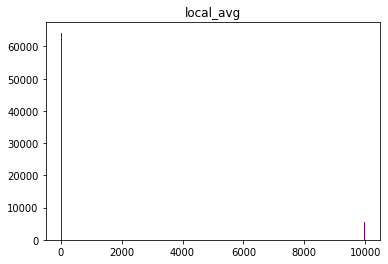

In [12]:
df1.hist(column='local_avg', bins=200, grid=False, rwidth=.9, color='purple')
df1['local_avg'].describe()

Histogram for 'remote_avg' response time (local) column


count    69745.000000
mean       793.170246
std       2682.048286
min          4.020000
25%          8.180000
50%          8.620000
75%          9.570000
max       9999.999900
Name: remote_avg, dtype: float64

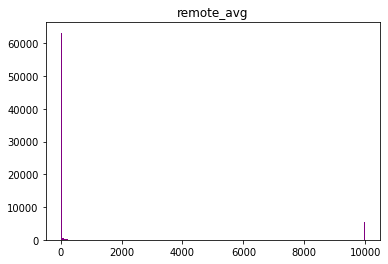

In [61]:
df1.hist(column='remote_avg', bins=200, grid=False, rwidth=.9, color='purple')
df1['remote_avg'].describe()

Duplicate the dataframe in case of crashes


In [13]:
df2 = df1.copy()

Map the local_delay and remote_delay to integers since that is what is needed by the classifier


In [14]:
df2['local_delay_int'] = df2['local_delay'].map({'Small':0, 'Medium':1, 'Large':2}).astype(int)
#df2['remote_delay_int'] = df2['remote_delay'].map({'Small':0, 'Medium':1, 'Large':2}).astype(int)
print(df2['local_delay_int'].unique())
#print(df2['remote_delay_int'].unique())
X = df2.drop(['index', 'timestamp', 'source', 'local_avg', 'remote_avg', 'local_delay', 'hour'], axis = 1)
y = df2['hour']
print(X.head())
print(y.head())

[2 1 0]
   ismean  gr500  gr55  gr40  gr30  gr20  gr10  gr0  local_delay_int
0       0      0     0     0     0     0     0    1                2
1       1      0     0     0     0     0     0    1                1
2       1      0     0     0     0     0     0    1                1
3       1      0     0     0     0     0     0    1                1
4       1      0     0     0     0     0     0    1                1
0    1
1    1
2    1
3    1
4    1
Name: hour, dtype: int32


Split out the test and train datasets


In [15]:
X_train, X_test, y_train, y_test= train_test_split(X, y,test_size=0.2,random_state=99)
print(X_train, y_train)

       ismean  gr500  gr55  gr40  gr30  gr20  gr10  gr0  local_delay_int
33973       1      0     0     0     0     0     0    1                1
68346       1      0     0     0     0     0     0    1                1
18644       1      0     0     0     0     0     0    1                1
11347       1      0     0     0     0     0     0    1                1
59206       1      0     0     0     0     0     0    1                1
...       ...    ...   ...   ...   ...   ...   ...  ...              ...
57042       1      0     0     0     0     0     0    1                1
36008       1      0     0     0     0     0     0    1                1
46265       0      0     0     0     0     0     0    1                2
23587       1      0     0     0     0     0     0    1                1
29313       0      0     0     0     0     0     0    1                2

[55796 rows x 9 columns] 33973    0
68346    2
18644    1
11347    2
59206    2
        ..
57042    1
36008    1
46265    2

### Use scikit-learn for Logistic Regression and DecisionTree Classification, XGBoost, Keras, Pytorch to train, test and predict a categorical variable. Use appropriate metric and interpret themeaning of the score

### Logistic Regression

In [65]:
LogReg = LogisticRegression()

scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

LogReg.fit(X_train,y_train)

y_pred=LogReg.predict(X_test)

In [66]:
print('Classes', LogReg.classes_)
print('Intercept',LogReg.intercept_)
print("Coefficients", LogReg.coef_ )

Classes [0 1 2]
Intercept [-0.02235625 -0.02000223  0.04235849]
Coefficients [[-0.02669646  0.09006309 -0.0338244   0.0136457  -0.01528755  0.01955446
   0.00705299 -0.09012795 -0.03178324]
 [-0.01305177 -0.06378792  0.01748828 -0.03445265  0.02880389  0.01795731
  -0.00651506  0.06357021 -0.01419089]
 [ 0.03974822 -0.02627518  0.01633613  0.02080694 -0.01351633 -0.03751178
  -0.00053793  0.02655774  0.04597412]]


In [67]:
print("Accuracy", LogReg.score(X_test, y_test))
print(classification_report(y_test, LogReg.predict(X_test)))

Accuracy 0.3669080220804359
              precision    recall  f1-score   support

           0       0.54      0.13      0.21      4610
           1       0.24      0.00      0.01      4525
           2       0.35      0.93      0.51      4814

    accuracy                           0.37     13949
   macro avg       0.38      0.36      0.24     13949
weighted avg       0.38      0.37      0.25     13949



### Decision Tree
- Done by Viphu Nguyen and Eric Topmiller

In [68]:
clf = DecisionTreeClassifier(criterion='entropy', random_state=99)

In [69]:
clf.fit(X_train,y_train)
y_pred= clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.3669080220804359

##### Plot a Decision Tree

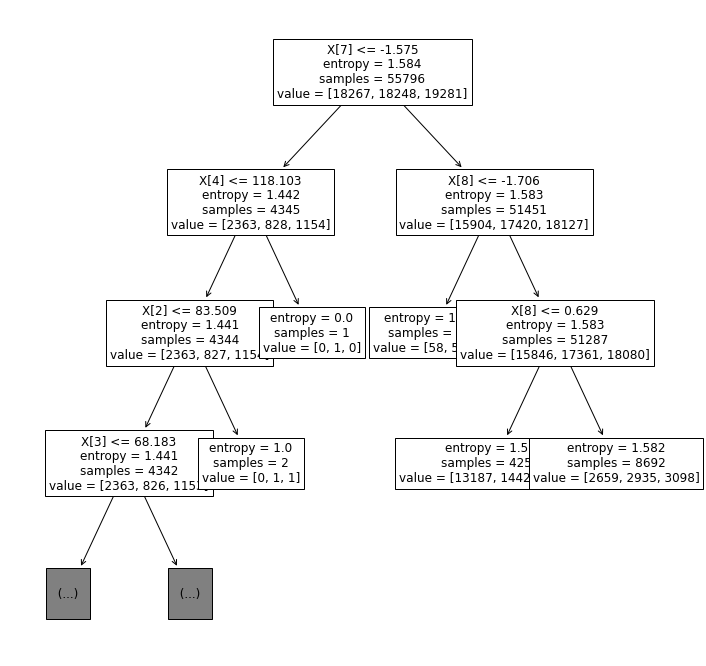

In [70]:
fig, ax = plt.subplots(figsize=(12, 12))
tree.plot_tree(decision_tree=clf, max_depth= 3,fontsize=12);

###  Show feature importance in XGBoost by using xgb.plot.importance

In [71]:
# !pip install xgboost
import xgboost as xgb
xg_cl = xgb.XGBClassifier(objective='binary:logistic', max_depth=10, n_estimators=100, seed=99) 
xg_cl.fit(X_train, y_train)
preds = xg_cl.predict(X_test)
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]
print("accuracy: %f" % (accuracy))

accuracy: 0.366908


## Keras
### model from https://www.kaggle.com/code/nitinsss/time-series-prediction-with-keras-for-beginners/notebook

In [72]:
# uninstall existing tensorflow-macos and tensorflow-metal
# !pip uninstall tensorflow-macos
# !pip uninstall tensorflow-metal
# !pip install tensorflow-macos
# !pip install tensorflow-metal
# # Upgrade tensorflow-deps
# !pip install tensorflow-deps --force-reinstall
# # or point to specific conda environment
# #conda install -c apple tensorflow-deps --force-reinstall -n my_env 
# !pip install tensorflow

from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD

ERROR: Could not find a version that satisfies the requirement tensorflow-macos (from versions: none)
ERROR: No matching distribution found for tensorflow-macos


^C


ERROR: Could not find a version that satisfies the requirement tensorflow-metal (from versions: none)
ERROR: No matching distribution found for tensorflow-metal
ERROR: Could not find a version that satisfies the requirement tensorflow-deps (from versions: none)
ERROR: No matching distribution found for tensorflow-deps


Create the model input layers


In [ ]:
input_layer = Input(shape=(9), dtype='float32')
dense1 = Dense(60, activation='linear')(input_layer)
dense2 = Dense(60, activation='linear')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='linear')(dropout_layer)

In [ ]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 9)]               0         
                                                                 
 dense (Dense)               (None, 60)                600       
                                                                 
 dense_1 (Dense)             (None, 60)                3660      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 61        
                                                                 
Total params: 4,321
Trainable params: 4,321
Non-trainable params: 0
_________________________________________________________________


Make the dataframe like the kaggle example


In [ ]:
df3 = df2.copy()
df3.drop(['index', 'timestamp', 'source', 'local_avg', 'remote_avg', 'local_delay'], axis = 1, inplace=True)
df3.head()
df_new = df3.copy()

Create the training, validation, and test inputs


In [ ]:
df_copy = df3.copy()
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (62944, 9) (62944,)
Shape of validation inputs, validation target: (3313, 9) (3313,)
Shape of test inputs, test target: (3488, 9) (3488,)


We will normalize our data in the range in the range (0.01, 0.99) before feeding it to the the neural network.


In [ ]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

Training and validation


In [ ]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=30, verbose=1, validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/30
12589/12589 [==============================] - 16s 1ms/step - loss: 0.1674 - val_loss: 0.2441
Epoch 2/30
12589/12589 [==============================] - 12s 972us/step - loss: 0.1635 - val_loss: 0.2347
Epoch 3/30
12589/12589 [==============================] - 12s 947us/step - loss: 0.1630 - val_loss: 0.2411
Epoch 4/30
12589/12589 [==============================] - 12s 941us/step - loss: 0.1630 - val_loss: 0.2414
Epoch 5/30
12589/12589 [==============================] - 12s 936us/step - loss: 0.1630 - val_loss: 0.2364
Epoch 6/30
12589/12589 [==============================] - 12s 985us/step - loss: 0.1629 - val_loss: 0.2351
Epoch 7/30
12589/12589 [==============================] - 13s 997us/step - loss: 0.1629 - val_loss: 0.2386
Epoch 8/30
12589/12589 [==============================] - 12s 952us/step - loss: 0.1629 - val_loss: 0.2302
Epoch 9/30
12589/12589 [==============================] - 12s 916us/step - loss: 0.1629 - val_loss: 0.2363
Epoch 10/30
12589/12589 [==============

Do the prediction


In [ ]:
y_pred = model.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

Find the R2 score


In [ ]:
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: -0.382


In [ ]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual 8 hour period'])

y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted 8 hour period'])

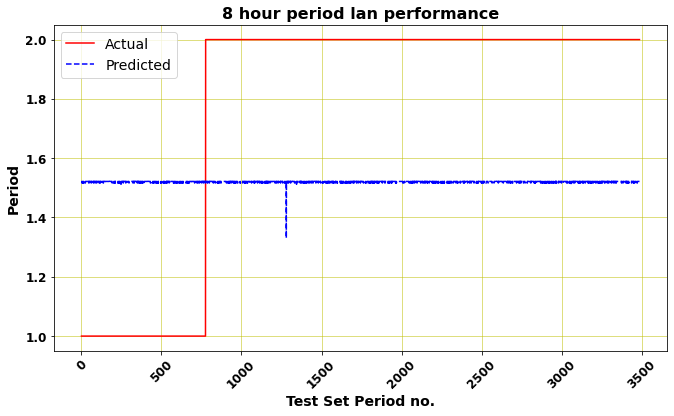

In [ ]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual','Predicted'], loc='best', prop={'size': 14})
plt.title('8 hour period lan performance', weight='bold', fontsize=16)
plt.ylabel('Period', weight='bold', fontsize=14)
plt.xlabel('Test Set Period no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

## Pytorch on Neural Network

In [16]:
# importing pytorch libraries
# !pip install torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F



In [17]:
df4 = df2.copy()
df4

,index,timestamp,source,local_avg,remote_avg,hour,local_delay,ismean,gr500,gr55,gr40,gr30,gr20,gr10,gr0,local_delay_int
0,0,1.559041e+09,ethernet,0.19,8.14,1,Large,0,0,0,0,0,0,0,1,2
1,1,1.559041e+09,ethernet,0.15,7.75,1,Medium,1,0,0,0,0,0,0,1,1
2,2,1.559041e+09,ethernet,0.15,8.68,1,Medium,1,0,0,0,0,0,0,1,1
3,3,1.559041e+09,ethernet,0.15,8.08,1,Medium,1,0,0,0,0,0,0,1,1
4,4,1.559041e+09,ethernet,0.15,8.20,1,Medium,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69740,69740,1.559691e+09,ethernet,0.15,8.70,2,Medium,1,0,0,0,0,0,0,1,1
69741,69741,1.559691e+09,ethernet,0.15,8.43,2,Medium,1,0,0,0,0,0,0,1,1
69742,69742,1.559691e+09,ethernet,0.15,8.71,2,Medium,1,0,0,0,0,0,0,1,1
69743,69743,1.559691e+09,ethernet,0.15,8.42,2,Medium,1,0,0,0,0,0,0,1,1


In [18]:
cols = ['local_avg', 'remote_avg', 'local_delay']
df4 = df4[cols]
df4

,local_avg,remote_avg,local_delay
0,0.19,8.14,Large
1,0.15,7.75,Medium
2,0.15,8.68,Medium
3,0.15,8.08,Medium
4,0.15,8.20,Medium
...,...,...,...
69740,0.15,8.70,Medium
69741,0.15,8.43,Medium
69742,0.15,8.71,Medium
69743,0.15,8.42,Medium


Converting the small, medium, and large to [0, 1, 2]


In [19]:
df4['local_delay'].replace({'Small': 0, 'Medium': 1, 'Large': 2}, inplace = True)

C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


To display the histogram of how often the response time is for the local delay input network 


C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


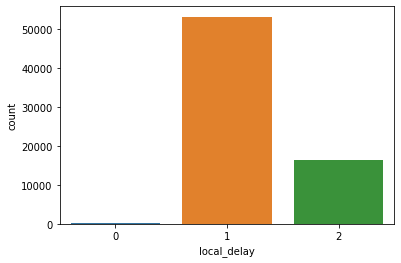

In [20]:
sns.countplot(df4.local_delay);

To look at the percentage of how much impact is the response time for local delay 


In [21]:
df4.local_delay.value_counts() / df4.shape[0]

1    0.76285
2    0.23411
0    0.00304
Name: local_delay, dtype: float64

To split the data into train and test sets:


In [22]:
X = df4[['local_avg', 'remote_avg']]
y = df4[['local_delay']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Convert all of it to Tensors (so we can use it with PyTorch)


In [30]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


AttributeError: 'Tensor' object has no attribute 'to_numpy'

### Building a Neural Network

In [24]:
class Net(nn.Module):
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

net = Net(X_train.shape[1])
net

Net(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)

In [25]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
X_train = X_train.to(device)
y_train = y_train.to(device)

X_test = X_test.to(device)
y_test = y_test.to(device)


In [27]:
net = net.to(device)

criterion = criterion.to(device)

In [28]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    
    y_pred = net(X_train)
    
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(f'''epoch {epoch} Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
            Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
            ''')
    
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0 Train set - loss: 16.207, accuracy: 0.731
            Test  set - loss: 15.937, accuracy: 0.732
            
epoch 100 Train set - loss: -8.092, accuracy: 0.763
            Test  set - loss: -7.941, accuracy: 0.764
            
epoch 200 Train set - loss: -8.174, accuracy: 0.763
            Test  set - loss: -8.027, accuracy: 0.764
            
epoch 300 Train set - loss: -8.252, accuracy: 0.763
            Test  set - loss: -8.094, accuracy: 0.764
            
epoch 400 Train set - loss: -8.326, accuracy: 0.763
            Test  set - loss: -8.182, accuracy: 0.764
            
epoch 500 Train set - loss: -8.402, accuracy: 0.763
            Test  set - loss: -8.249, accuracy: 0.764
            
epoch 600 Train set - loss: -8.481, accuracy: 0.763
            Test  set - loss: -8.334, accuracy: 0.764
            
epoch 700 Train set - loss: -8.557, accuracy: 0.763
            Test  set - loss: -8.396, accuracy: 0.764
            
epoch 800 Train set - loss: -8.636, accuracy: 0.76

### Evaluation on the Neural Network (Pytorch)

In [29]:
classes = ['Low', 'Medium', 'Large']
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

         Low       0.00      0.00      0.00        42
      Medium       0.76      1.00      0.87     10655
       Large       0.00      0.00      0.00      3252

    accuracy                           0.76     13949
   macro avg       0.25      0.33      0.29     13949
weighted avg       0.58      0.76      0.66     13949



C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\VIphu N\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1318

## Compare the results of the algorithms (comparison, conclusion, challenges...etc.)

### **Comparison**

**Logistic Regression Accuracy:** 0.3669080220804359

**Decision Tree Classifier:** 0.3669080220804359

**XGBoost Classifier Accuracy:** 0.366908

**Keras Model R-squared score for the test set:** -0.382

**Neural Network with Pytorch Accuracy:** 0.76



### **Conclusion**

The Logistic Regression had a accuracy of 0.37, which indicates that there is not a strong correlation.

We can see that the Decision Tree Classifier had a low entropy at ~0.367. Entropy is the degree of randomness which in this case, and the lower score helps in drawing accurate conclusions from the information that is provided.

The XGBoost score was ~0.367 as well, which shows the accuracy of the trained model on the test set. 

The Keras Model R-Squared score is negative at -0.382, indicating that the chosen model fits the data quite poorly. This implies that the chosen model does not follow the trend of the data and fits worse than a horizontal line in this case.

The Neural Network with Pytorch had an accuracy of ~0.76. A smaller loss indicated from the algebraicallly-more negative results (ranging from -7.9 to -8.5) should signify better predictions. The model is not perfect as of yet but it does perform relatively well all things considered.




### **Challenges**

We had multiple Jupyter notebooks for our datasets based on ethernet local, remote, wireless-local, etc. It took time to decide which dataset we wanted to follow through with. Our target variable was also not categorical at first, but we fixed this issue by using the day hour, with three 8-hour segments 
(0-8, 8-16, 16-23).

There were many rows where the average was 9999.9999 since they were failures which could have skewed the data. These values turned out to be red herrings, meaning that it was intended to be misleading or distracting in the context of the models. If we removed the failures, we would have had .996 accuracy but since they were intended, we had to work with that information at the cost of a less accurate model.

### Outcome of our analysis

We aimed to answer what the worst time of day was for a ping response with ethernet and wireless for both LAN and WAN. After performing the tests for each of the datasets, we decided to analyze the ping response for LAN ethernet.

Target Variable: Day-Hour - 0, 1, or 2
0: 0-8am
1: 8am-4pm
2: 4pm-12am


From the plots, graphs, and models created out of the data, we can see that 1 (8am-4pm) has the highest local delay, followed by 2 (4pm-12am) and then 0 (0-8am).